In [5]:
import tensorflow as tf
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

### Sample-level sentence removal

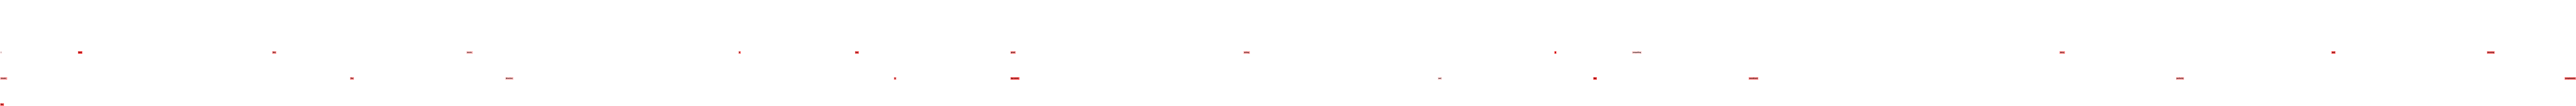

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import textwrap

def visualize_importance(text, importance, wrap_width=80):
    # Define colors
    colors = LinearSegmentedColormap.from_list('importance', ['white', 'red'])

    # Split the text into words
    words = text.split()
    importance_values = importance[:len(words)]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot each word with the corresponding importance, handling line wrapping
    current_line_length = 0
    line_height = 1
    for i, (word, importance_value) in enumerate(zip(words, importance_values)):
        if current_line_length + len(word) + 1 > wrap_width:
            current_line_length = 0
            line_height += 1
        ax.text(current_line_length, -line_height, word, fontsize=12, weight='bold',
                backgroundcolor=colors(importance_value))
        current_line_length += len(word) + 1

    # Remove axes
    ax.axis('off')

    # Adjust layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()

# Example usage
text = ("I love this movie. It has great acting, a compelling story, and stunning visuals. "
        "The direction is top-notch, and the soundtrack perfectly complements the scenes. "
        "Overall, it is a fantastic film experience.")
importance = [0.1, 0.8, 0.5, 0.3, 0.6, 0.7, 0.5, 0.4, 0.8, 0.2, 0.5, 0.7, 0.6, 0.4, 0.5, 0.3, 0.6, 0.7, 0.2, 0.8, 0.5, 0.4, 0.6, 0.7]
visualize_importance(text, importance)


In [5]:
prop = "h"
saved_path = f'../elemnet/model/mof_{prop}_racs_dband_tl'
# elemnet/sample/alignn_matbert-base-cased_robo_prop_formation_energy_peratom.config

with open('{}.json'.format(saved_path), 'r') as json_file:
    json_savedModel= json_file.read()
model = tf.keras.models.model_from_json(json_savedModel) 

model.load_weights("{}.h5".format(saved_path))

print("Loaded model from disk")

adam = optimizers.Adam(lr=0.0001)
model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=adam, metrics=['mean_absolute_error'])

Loaded model from disk


/scratch/yll6162/miniconda3/envs/tl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
# prop = 'formation_energy_peratom'

if prop == "oxo":
    prop_name = 'Oxo Formation Energy'
elif prop == 'h':
    prop_name = 'Hydrogen Affinity Energy'

test_path = f'/scratch/yll6162/MOF-oxo/data/query_unlabel_mof_dband_embed_{prop_name}_first_row.csv'
pred = pd.read_csv(test_path) 
# pred = pd.read_csv(test_path) 
pred_elem = pred[pred.columns[:-1]]

new_x_pred = pred_elem.values
new_x_pred = np.asarray(new_x_pred, dtype=np.float)
predictions = model.predict(new_x_pred, batch_size=32)

print(predictions)

[[-2.589046 ]
 [-2.1758823]
 [-1.557031 ]
 ...
 [-2.2072058]
 [-2.4244099]
 [-2.3362932]]


In [7]:
# Generate prediction uncertainties
# Define the Monte Carlo Dropout function

qbc = 30
def monte_carlo_dropout(model, x, n_samples=100):
    results = np.zeros((n_samples, x.shape[0]))
    for i in range(n_samples):
        results[i] = model.predict(x, batch_size=32).ravel()
    return results
predictions = monte_carlo_dropout(model, new_x_pred, n_samples=qbc)
df_all = pd.DataFrame(predictions.T, columns=[f'pred_{i}' for i in range(qbc)])
df_all['ids_test'] = pred['ids']
# Use Monte Carlo Dropout to get predictions and uncertainty estimates


row_variances = df_all.drop('ids_test', axis=1).var(axis=1)

df_all['row_variances'] = row_variances
df_all['row_std'] = np.sqrt(row_variances)
df_sorted = df_all.sort_values(by='row_variances', ascending=False)
output_dir = "/scratch/yll6162/MOF-oxo/output"
df_sorted.to_csv(os.path.join(output_dir, f"dband_racs_tl_pred_{prop}_idx_iter_all_var_query_2.csv"))
# df_sorted.to_csv(os.path.join(args.output_dir, f"dband_racs_tl_pred_{prop}_idx_iter_all_var_query_2.csv"))